In [83]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from graspologic.embed import ClassicalMDS
from utils import calculate_dissim

# Clustering Dissimilarity Matrices
Here we will use some well-known clustering algorithms (Agglomerative clustering, GMM, K-means) from sklearn to cluster networks on the dissimilarity matrices that we generated in the discriminability notebook.

## Load Data

In [4]:
from graspologic.datasets import load_mice
from grakel import Graph

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

# Convert adjacency matrices to grakel objects
Gs = []
for graph in graphs:
    Gs.append(Graph(initialization_object = graph, node_labels=labels))
print(len(Gs))

(32, 332, 332)
32


In [92]:
def cluster_dissim(dissim_matrix: np.ndarray, labels: list, method="agg"):
    if method == "agg":
        # Agglomerative clustering
        agg = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average', \
            compute_distances=True).fit(dissim_matrix, y=labels)

        # construct linkage matrix
        counts = np.zeros(agg.children_.shape[0])
        n_samples = len(agg.labels_)

        for i, merge in enumerate(agg.children_):
            temp_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    temp_count += 1 
                else:
                    temp_count += counts[child_idx - n_samples]
            counts[i] = temp_count

        linkage_matrix = np.column_stack([agg.children_, agg.distances_, counts]).astype(float)

        return linkage_matrix
    
    elif method in ["gmm", "kmeans"]:
        # Classical MDS
        cmds = ClassicalMDS(n_components=2, dissimilarity="precomputed")
        cmds_embedding = cmds.fit_transform(dissim_matrix)

        # cluster using GMM or K-means
        if method == "gmm":
            clustering = GaussianMixture(n_components=4, random_state=42).fit_predict(cmds_embedding, y=labels)
        elif method == "kmeans":
            clustering = KMeans(n_clusters=4, random_state=42).fit_predict(cmds_embedding, y=labels)
        else:
            print("Not a valid kernel name.")

        return cmds_embedding, clustering
    
    else:
        print("Not a valid kernel name.")

## Agglomerative Clustering

In [96]:
# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# set palette for plotting
df = pd.DataFrame(mice.labels, columns = ['Labels'])
mice_labels = df.pop("Labels")
palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}
colors = mice_labels.map(palette).to_numpy()

### Density

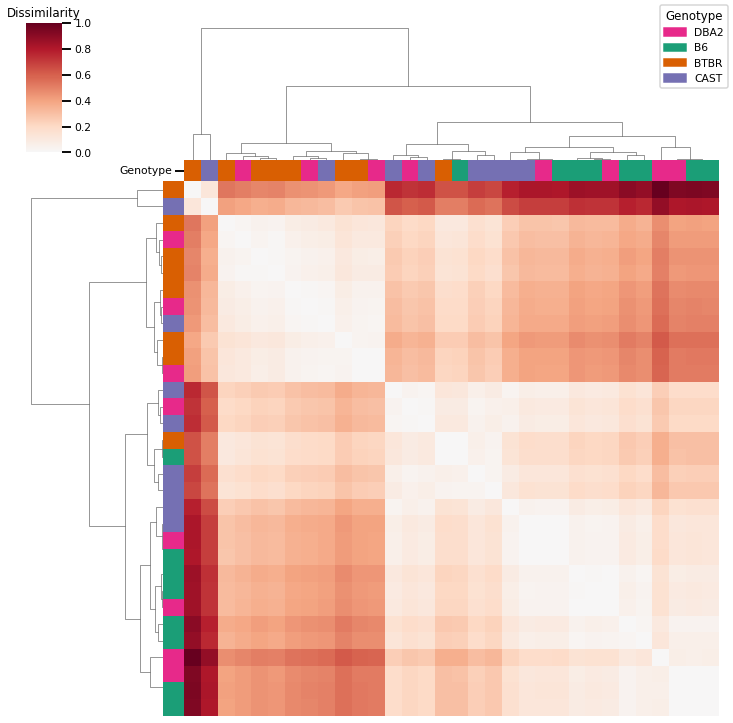

In [99]:
# calculate dissimilarity matrix
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

# cluster dissimilarity matrix
density_linkage_matrix = cluster_dissim(scaled_density_dissim, y, method="agg")

# plot clustered dissimilarity matrix
sns.set_context("talk", font_scale=0.65)
clustergrid = sns.clustermap(
    scaled_density_dissim,
    row_linkage=density_linkage_matrix,
    col_linkage=density_linkage_matrix,
    row_colors = colors,
    col_colors = colors,
    cmap="RdBu_r",
    center=0,
    xticklabels=False,
    yticklabels=False,
)

clustergrid.figure.set_facecolor('w')
clustergrid.ax_cbar.set_title("Dissimilarity") # add color bar
col_ax = clustergrid.ax_col_colors # add row and column colors
col_ax.set_yticks([0.5])
_ = col_ax.set_yticklabels(["Genotype"], va="center")
patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in palette.items()] # add legend
clustergrid.figure.legend(handles=patches, loc='upper right', title='Genotype')

### Average Edge Weight

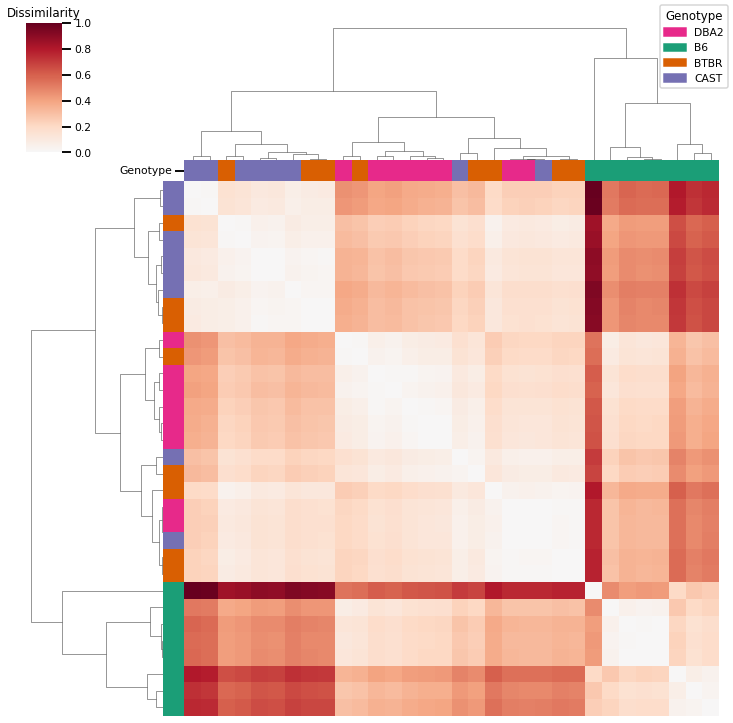

In [100]:
# calculate dissimilarity matrix
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

# cluster dissimilarity matrix
avgedgeweight_linkage_matrix = cluster_dissim(scaled_avgedgeweight_dissim, y, method="agg")

# plot clustered dissimilarity matrix
sns.set_context("talk", font_scale=0.65)
clustergrid = sns.clustermap(
    scaled_avgedgeweight_dissim, 
    row_linkage=avgedgeweight_linkage_matrix, 
    col_linkage=avgedgeweight_linkage_matrix,
    row_colors = colors,
    col_colors = colors,
    cmap="RdBu_r",
    center=0,
    xticklabels=False,
    yticklabels=False,
)

clustergrid.figure.set_facecolor('w')
clustergrid.ax_cbar.set_title("Dissimilarity") # add color bar
col_ax = clustergrid.ax_col_colors # add row and column colors
col_ax.set_yticks([0.5])
_ = col_ax.set_yticklabels(["Genotype"], va="center")
patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in palette.items()] # add legend
clustergrid.figure.legend(handles=patches, loc='upper right', title='Genotype')

### Average of Adjacency Matrix

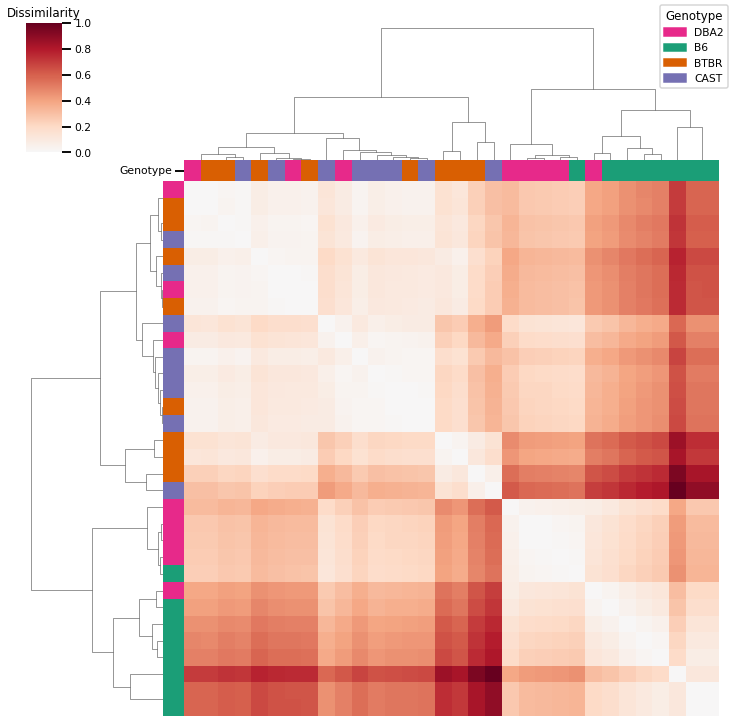

In [101]:
# calculate dissimilarity matrix
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

# cluster dissimilarity matrix
avgadjmat_linkage_matrix = cluster_dissim(scaled_avgadjmat_dissim, y, method="agg")

# plot clustered dissimilarity matrix
sns.set_context("talk", font_scale=0.65)
clustergrid = sns.clustermap(
    scaled_avgadjmat_dissim, 
    row_linkage=avgadjmat_linkage_matrix, 
    col_linkage=avgadjmat_linkage_matrix,
    row_colors = colors,
    col_colors = colors,
    cmap="RdBu_r",
    center=0,
    xticklabels=False,
    yticklabels=False,
)

clustergrid.figure.set_facecolor('w')
clustergrid.ax_cbar.set_title("Dissimilarity") # add color bar
col_ax = clustergrid.ax_col_colors # add row and column colors
col_ax.set_yticks([0.5])
_ = col_ax.set_yticklabels(["Genotype"], va="center")
patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in palette.items()] # add legend
clustergrid.figure.legend(handles=patches, loc='upper right', title='Genotype')

## GMM

In [102]:
# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# set palette for plotting
palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}

# dict for mapping int labels to strings
mapper_inv = {0: 'B6', 1: 'BTBR', 2: 'CAST', 3: 'DBA2'}

### Density

<AxesSubplot:xlabel='Dimension 1', ylabel='Dimension 2'>

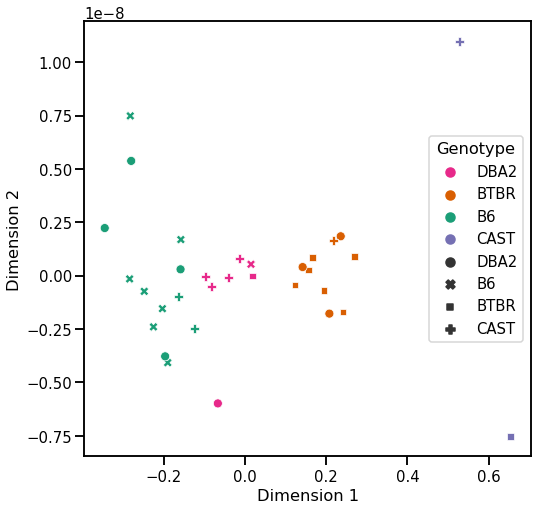

In [104]:
# cluster dissimilarity matrix
density_cmds_embedding, density_gm = cluster_dissim(scaled_density_dissim, y, method="gmm")
density_cmds_embedding = pd.DataFrame(density_cmds_embedding, columns=["Dimension 1", "Dimension 2"])

density_gm = np.array([mapper_inv[l] for l in list(density_gm)])
density_cmds_embedding["Genotype"] = density_gm

# plot clustering
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='w')
sns.set_context("talk", font_scale=0.9)
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue="Genotype", style=mice.labels, data=density_cmds_embedding, palette=palette, ax=ax)

## K-Means
### Density

<AxesSubplot:xlabel='Dimension 1', ylabel='Dimension 2'>

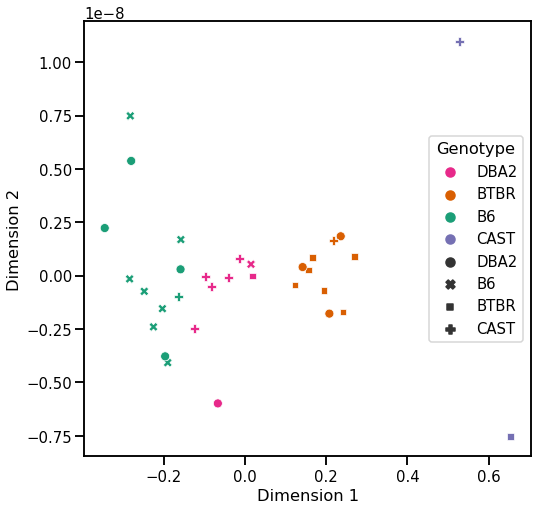

In [105]:
# cluster dissimilarity matrix
density_cmds_embedding, density_km = cluster_dissim(scaled_density_dissim, y, method="kmeans")
density_cmds_embedding = pd.DataFrame(density_cmds_embedding, columns=["Dimension 1", "Dimension 2"])

density_km = np.array([mapper_inv[l] for l in list(density_km)])
density_cmds_embedding["Genotype"] = density_km

# plot clustering
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='w')
sns.set_context("talk", font_scale=0.9)
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue="Genotype", style=mice.labels, data=density_cmds_embedding, palette=palette, ax=ax)